In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from PIL import Image
from tqdm import tqdm
import os
import math

from scipy import stats

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

from Seq2Seq import Seq2Seq

def show(x_test,target,idx,model):
    a=np.expand_dims(x_test[target+idx], axis=0)
    prd=model.predict(a)
    aa=[]
    for b in prd[0][-1]:
        bb=[]
        for c in b:
            bb.append([c,c,c])
        aa.append(bb)
    aa=np.array(aa)[:,:,:,0]
    if idx==0:
        predict=np.expand_dims(aa,axis=0)
    else:
        predict = np.concatenate((predict, np.expand_dims(aa,axis=0)), axis=0)
def MAPE(y_test, y_pred,vervose=1):
    # print(y_test.shape, y_pred.shape)
    all=(zip(y_test,y_pred))
    
    cnt=0
    cost=0
    up=0
    down=0
    for t,p in all:#t로나눠
        if t==0:
            # c=np.abs(t-p) / p
            continue
        else:
            c=np.abs(t-p) / t
            cnt+=1
            cost+=c
            # if c>0.5:
            #     if t> 40:
            #         up+=1
            #     else:
            #         down+=1
            # if c>0.2:
            #     print(t)
    if vervose==1:
        print(f"up: {up}  down : {down}")
    return cost/cnt*100


def compute_metrics(original,predict,start,end,is_pval=0):
    start-=1
    end-=1
    y=original[:,start:end,:,:]
    y_pred=predict[:,start:end,:,:]
    
    # mape=MAPE(y.reshape(-1,),y_pred.reshape(-1,))
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()

    mape=MAPE(y_flatten,y_pred_flatten,0)

    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    p_val=stats.chisquare(y_flatten,y_pred_flatten)[1]

    if is_pval==1:
        return np.array([mse,mape,mae,p_val])
    
    return np.array([mse,mape,mae])



def metrics_(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()

    mape=MAPE(y_flatten,y_pred_flatten)
    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    return [mse,mape,mae]

def metrics_jam(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100
    # 속도 40이하만 필터링
    y_filtered=y[y <40]
    y_pred_filtered=y_pred[y < 40]

    
    mape=MAPE(y_filtered,y_pred_filtered)
    mse=mean_squared_error(y_filtered,y_pred_filtered)
    mae=mean_absolute_error(y_filtered,y_pred_filtered)
    return [mse,mape,mae]

def _predict(models,i, x_test ,target):
    for idx in range(7):
        a=np.expand_dims(x_test[target+idx], axis=0)
        #1 7 24 31 1
        prd=models[i](a)

        #gray에서 이미지보여주려고 ch3만듬
        all=[]
        #예측된거 마지막꺼만 가져옴
        for img in prd[0][-1]:
            pixel=[]
            for gray in img:
                pixel.append([gray,gray,gray])
            all.append(pixel)
        all=np.array(all)[:,:,:,0]
    
        if idx==0:
            predict=np.expand_dims(all,axis=0)
        else:
            predict = np.concatenate((predict, np.expand_dims(all,axis=0)), axis=0)
    return predict



def make_predict(models, model_num, x_test ,target,original):
    predicts=[]
    for i in range(model_num):
    
        predict=_predict(models,i,x_test,target)
        print()
        print(f"{i}번째")
        print("속도 전체 에러율")
        mse,mape,mae=metrics_(original[:,:,:,0],predict[:,:,:,0])
        print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")
        # print("속도 40이하 에러율")
        # mse,mape,mae=metrics_jam(original[:,:,:,0],predict[:,:,:,0])
        # print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")

        #모든 모델 확인하기 위해 리스트에 저장
        predicts.append(predict)
    return predicts


# test all 2020

In [ ]:
path="D:/npz_gray_7_64_fix"


models=[]

tf.keras.backend.set_floatx('float32')

model = Seq2Seq(16, 4, 4)
model.build(input_shape=(1,7,24,31,1))
model.load_weights("seq2seq_inside_64_0.0006_mse_4_2800_0.1.h5")
models.append(model)

model2 = Seq2Seq(16, 4, 4)
model2.build(input_shape=(1,7,24,31,1))
model2.load_weights("seq2seq_inside_64_0.0006_mse_4_3000_0.1.h5")
models.append(model2)

model3 = Seq2Seq(16, 4, 4)
model3.build(input_shape=(1,7,24,31,1))
model3.load_weights("seq2seq_inside_64_0.0006_mse_4_600_0.1.h5")
models.append(model3)

# model4 = Seq2Seq(16, 4, 4)
# model4.build(input_shape=(1,7,24,31,1))
# model4.load_weights("seq2seq_KangByeon_64_0.001_mse_4_1000_0.1.h5")
# models.append(model4)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


0번째
속도 전체 에러율
up: 0  down : 0
rmse : 4.655632347542806 , mape : 6.244958598760677 , mae : 3.1680922423885303

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this

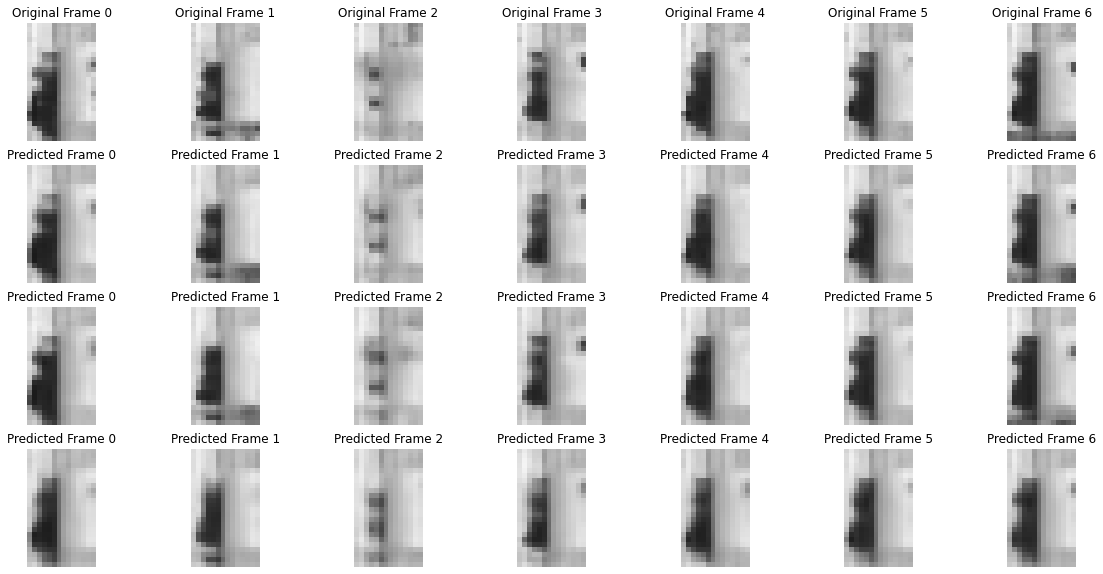

In [ ]:
# 모든 모델 훈련시킨걸로 확인하기
x_test = np.load(f"{path}/batch/x/3.npz")['x']
target=2 # 
originals=[]
predicts=[]

model_num=len(models)

#원본데이터
original=x_test[target+7]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))
# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    #inverse여서 1에서 빼준다
    ax.imshow((original[idx]))
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")




0번째
속도 전체 에러율
up: 0  down : 0
rmse : 5.287187677033307 , mape : 7.189984999781742 , mae : 3.73138154574644

1번째
속도 전체 에러율
up: 0  down : 0
rmse : 5.302161890641476 , mape : 6.8794269612345085 , mae : 3.6786604751121597

2번째
속도 전체 에러율
up: 0  down : 0
rmse : 7.869705867896243 , mape : 10.570997803720235 , mae : 5.263257411133056


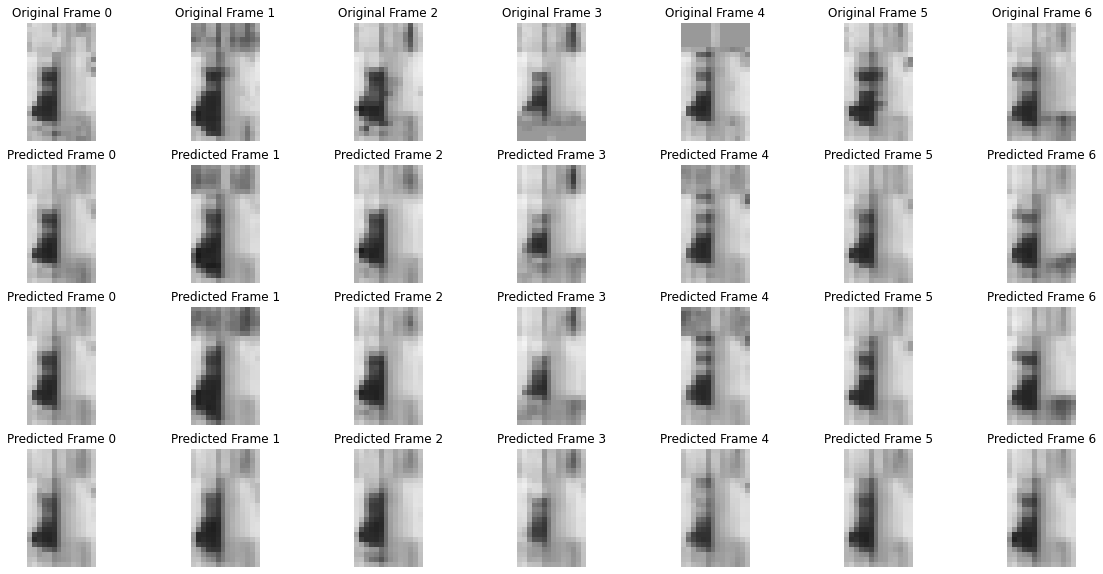

In [ ]:
# 모든 모델 새로운데이터로 확인하기

x_test = np.load(f"{path}/2020/1.npz")['arr_0']
target=8 # 
originals=[]
predicts=[]
model_num=len(models)

#원본데이터
original=x_test[target+7]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(original[idx])
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")


## 2020년 1개만 먼저 테스트해보기

In [ ]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
batch_size=32
win=7
total=[]
for k in range(len(models)):
    before_list=[]
    after_list=[]
    peak_list=[]
    rest_list=[]
    # for i in tqdm(list):
    x_test = np.load(f"{path}/2020/4.npz")['arr_0']
    for target in range(batch_size-win):
        predict=_predict(models,k,x_test,target)
        original=x_test[target+7]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        original=np.array(all)[:,:,:,:,0]
        #before peak hour - 7~12
        before=compute_metrics(original,predict,7,12)
        #peak 12~19
        peak=compute_metrics(original,predict,12,19)
        #after 19~21
        after=compute_metrics(original,predict,19,21)
        #rest 22~24 , 0~6
        y=original[:,21:23,:,:]
        y_pred=predict[:,21:23,:,:]
        # 22~24 0~6 시간대 합치기
        y=np.concatenate((y,original[:,0:5,:,:]),axis=1)
        y_pred=np.concatenate((y_pred,predict[:,0:5,:,:]),axis=1)
        # rest 에러 계산
        y=(y)*100
        y_pred=(y_pred)*100
        y_flatten=y.flatten()
        y_pred_flatten=y_pred.flatten()
        mape=MAPE(y_flatten,y_pred_flatten,0)
        mse=mean_squared_error(y_flatten,y_pred_flatten)
        mae=mean_absolute_error(y_flatten,y_pred_flatten)
        rest=[mse,mape,mae]
        
        #전체 저장
        before_list.append(before)
        after_list.append(after)
        peak_list.append(peak)
        rest_list.append(rest)
        # print(len(before),len(after),len(peak),len(rest))
        # print(before.shape,after.shape,peak.shape,rest.shape)

    total.append(np.array((np.array(before_list),np.array(peak_list),np.array(after_list),np.array(rest_list))))
total=np.array(total)

In [ ]:
# mse,mape,mae
for i in range(len(models)):
    print(f"{i}번째")
    print("before")
    print(np.mean(total[i][0],axis=0))
    print("peak")
    print(np.mean(total[i][1],axis=0))
    print("after")
    print(np.mean(total[i][2],axis=0))
    print("rest")
    print(np.mean(total[i][3],axis=0))
    print("표준편차")
    print("before")
    print(np.std(total[i][0],axis=0))
    print("peak")
    print(np.std(total[i][1],axis=0))
    print("after")
    print(np.std(total[i][2],axis=0))
    print("rest")
    print(np.std(total[i][3],axis=0))

0번째
before
[30.64311653  6.78735977  3.67542033]
peak
[23.72627789  7.1459198   3.28825281]
after
[20.88145862  7.14018959  2.88773138]
rest
[22.20072288  5.13198467  3.27722554]
표준편차
before
[8.46320987 1.32471899 0.47811995]
peak
[3.60936839 0.83783764 0.31532637]
after
[5.12354267 0.93901561 0.43449574]
rest
[4.20249391 0.71014005 0.33450759]
1번째
before
[22.63990691  5.76309498  3.32681722]
peak
[19.16180112  5.80602981  2.94592568]
after
[13.59964415  5.57606195  2.40837137]
rest
[21.02780334  4.83461216  3.14767517]
표준편차
before
[5.40503315 0.84159496 0.33375502]
peak
[2.87287332 0.6001175  0.26709913]
after
[4.33226475 0.63482523 0.32916219]
rest
[5.94517822 0.85278825 0.4690573 ]
2번째
before
[65.11462885  9.94733794  5.13063585]
peak
[52.6951941   9.31521639  4.28483106]
after
[36.66148245  8.92266677  3.61554319]
rest
[53.66643508  7.50928868  4.40359364]
표준편차
before
[15.57810789  1.96634823  0.53945258]
peak
[15.37731736  1.6801274   0.50410662]
after
[10.15190233  0.93166566  0.

## 지정 시간대 매트릭구하기

In [ ]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
batch_size=64
win=7
total=[]
model_num=1
num_2020=10 # 강변 10


for k in range(num_2020):
    before_list=[]
    after_list=[]
    peak_list=[]
    rest_list=[]
    # for i in tqdm(list):
    x_test = np.load(f"{path}/2020/{k}.npz")['arr_0']
    for target in range(batch_size-win):
        predict=_predict(models,model_num,x_test,target)
        original=x_test[target+7]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        
        original=np.array(all)[:,:,:,:,0]

        #before peak hour - 7~12
        before=compute_metrics(original,predict,7,12)
        #peak 12~19
        peak=compute_metrics(original,predict,12,19)
        #after 19~21
        after=compute_metrics(original,predict,19,21)

        #rest 22~24 , 0~6
        y=original[:,21:23,:,:]
        y_pred=predict[:,21:23,:,:]
        # 22~24 0~6 시간대 합치기
        y=np.concatenate((y,original[:,0:5,:,:]),axis=1)
        y_pred=np.concatenate((y_pred,predict[:,0:5,:,:]),axis=1)
        # rest 에러 계산
        y=(y)*100
        y_pred=(y_pred)*100
        y_flatten=y.flatten()
        y_pred_flatten=y_pred.flatten()
        mape=MAPE(y_flatten,y_pred_flatten,0)
        mse=mean_squared_error(y_flatten,y_pred_flatten)
        mae=mean_absolute_error(y_flatten,y_pred_flatten)
        
        rest=[mse,mape,mae]
        
        #전체 저장
        before_list.append(before)
        after_list.append(after)
        peak_list.append(peak)
        rest_list.append(rest)


    total.append(np.array((np.array(before_list),np.array(peak_list),np.array(after_list),np.array(rest_list))))
total=np.array(total)

In [ ]:
# mse,mape,mae
print("before")
print(np.mean(total[0][0],axis=0))
print("peak")
print(np.mean(total[0][1],axis=0))
print("after")
print(np.mean(total[0][2],axis=0))
print("rest")
print(np.mean(total[0][3],axis=0))
print("표준편차")
print("before")
print(np.std(total[0][0],axis=0))
print("peak")
print(np.std(total[0][1],axis=0))
print("after")
print(np.std(total[0][2],axis=0))
print("rest")
print(np.std(total[0][3],axis=0))

before
[20.1875093   5.22227684  3.08050679]
peak
[20.01349845  5.77622837  2.80508212]
after
[17.36829366  6.49993123  2.71076398]
rest
[26.14710297  5.66793464  3.48386777]
표준편차
before
[5.18418477 0.79623276 0.34226505]
peak
[5.7654399  1.05350278 0.38137637]
after
[8.16101253 1.44669891 0.57632592]
rest
[11.10297703  1.58476011  0.80212894]


## 모든 시간대 메트릭, 그래프구하기

In [ ]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
# 7일 단위로 끊기




total_7=[]
for k in range(num_2020):
    times=[]
    x_test = np.load(f"{path}/2020/{k}.npz")['arr_0']
    
    for target in range(0,batch_size-win,win):
        predict=_predict(models,model_num,x_test,target)
        
        
        original=x_test[target+7]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        original=np.array(all)[:,:,:,:,0]


        time=[]
        for i in range(1,25):
            time.append(compute_metrics(original,predict,i,i+1,is_pval=1))
        

        
        #전체 저장
        times.append(np.array(time))

    total_7.append(np.array(times))
total_7=np.array(total_7)
total_7=total_7.reshape(-1,24,4)

In [ ]:
rmse_list=[]
mape_list=[]
pval_list=[]
for time in range(24):
    #rmse
    rmse_list.append(np.mean(np.sqrt(total_7[:,time,0].astype(float))))
    #mape
    mape_list.append(np.mean(total_7[:,time,1]))
    #p_value
    pval_list.append(np.mean(total_7[:,time,3]))

In [ ]:
rmse_std=[]
mape_std=[]
for time in range(24):
    #rmse
    rmse_std.append(np.std(np.sqrt(total_7[:,time,0].astype(float)),axis=0))
    #mape
    mape_std.append(np.std(total_7[:,time,1],axis=0))
    #p_value
    # pval_list.append(np.mean(total_7[:,time,3]))

In [ ]:
rmse_list

[5.20737273269855,
 4.610222835633724,
 4.630440042156947,
 4.3656824449223555,
 3.899392618549243,
 3.547334123258483,
 4.023488420706378,
 4.798808419673757,
 4.996712306400522,
 4.841187799484731,
 4.775013413993282,
 4.619672897201608,
 4.510181209418928,
 4.66414771894104,
 4.433960251309165,
 4.349826884366592,
 4.250408240180949,
 4.019437541678928,
 3.7866316955685857,
 3.9609885761291297,
 4.699788884000663,
 5.332303502846816,
 5.604668461965007,
 5.243677111285812]

In [ ]:
mape_std

[1.5507110510724607,
 1.693341933474581,
 1.7045682219215814,
 1.8626754313154659,
 1.6069275681546467,
 1.2370115827489687,
 0.8060884793996244,
 1.19697064732835,
 1.5487345615460744,
 1.5739464177747353,
 1.6822849829520208,
 1.5767303660622085,
 1.3930301713784516,
 1.5139599540386246,
 1.2768879449474397,
 1.3919761617196098,
 1.9638207979479119,
 2.0256019037433797,
 1.5636112542199,
 1.3376365398900754,
 1.6087133795971293,
 1.9565476991636228,
 1.8905785472482335,
 1.631847705832517]

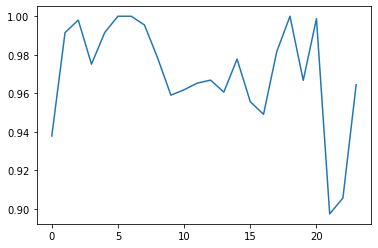

In [ ]:
plt.plot(range(24),pval_list)

In [ ]:
rmse_list

[5.20737273269855,
 4.610222835633724,
 4.630440042156947,
 4.3656824449223555,
 3.899392618549243,
 3.547334123258483,
 4.023488420706378,
 4.798808419673757,
 4.996712306400522,
 4.841187799484731,
 4.775013413993282,
 4.619672897201608,
 4.510181209418928,
 4.66414771894104,
 4.433960251309165,
 4.349826884366592,
 4.250408240180949,
 4.019437541678928,
 3.7866316955685857,
 3.9609885761291297,
 4.699788884000663,
 5.332303502846816,
 5.604668461965007,
 5.243677111285812]

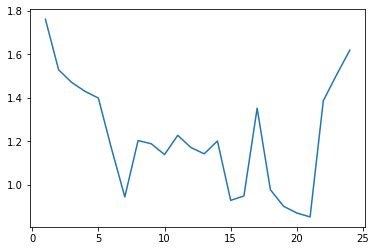

In [ ]:
plt.plot(range(1,25),rmse_std)

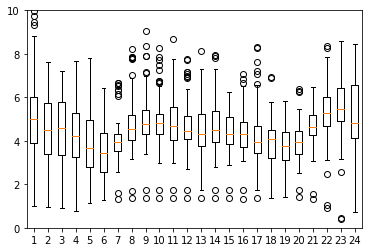

In [ ]:
fig, ax= plt.subplots()
ax.boxplot(np.sqrt(total_7[:,:,0].astype(float)))
ax.set_ylim(0,10)
plt.show()

In [ ]:
mape_list

[5.130906420654672,
 4.76074301906058,
 4.811062006234954,
 4.7674288458985945,
 3.8705135638501384,
 3.3752041646040825,
 4.233938499054892,
 5.417880779306554,
 5.987192728919899,
 6.1328296570141685,
 6.387324205644763,
 5.742411724216308,
 5.142146731688082,
 5.559062165837431,
 5.784677070757105,
 6.160512447624102,
 6.063330286932464,
 6.074161060786334,
 5.748133099722852,
 6.01099333138651,
 6.529407355282493,
 6.534867264546382,
 6.683339685418063,
 5.580433035386155]

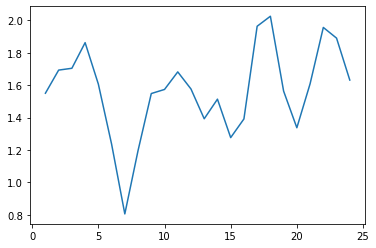

In [ ]:
plt.plot(range(1,25),mape_std)

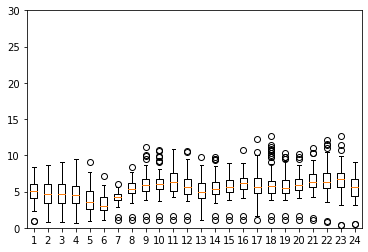

In [ ]:
fig, ax= plt.subplots()
ax.boxplot((total_7[:,:,1].astype(float)))
ax.set_ylim(0,30)
plt.show()


0번째
속도 전체 에러율
up: 0  down : 0
rmse : 4.732915522255999 , mape : 5.999704280796163 , mae : 3.0433400953087917

1번째
속도 전체 에러율
up: 0  down : 0
rmse : 4.455311700435536 , mape : 5.554552281804578 , mae : 2.961491214723385

2번째
속도 전체 에러율
up: 0  down : 0
rmse : 7.047978053779774 , mape : 8.516453465952706 , mae : 4.2158619614542365


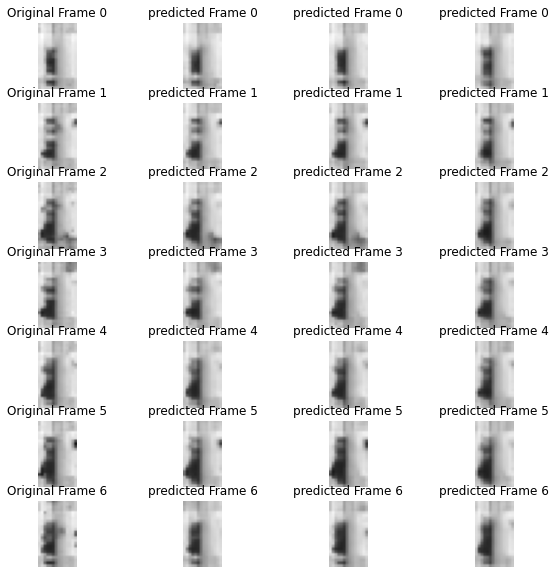

In [ ]:
# 모든 모델 새로운데이터로 확인하기

x_test = np.load(f"{path}/2020/7.npz")['arr_0']
target=6 # 
originals=[]
predicts=[]


#원본데이터
original=x_test[target+7]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]



predicts=make_predict(models, len(models), x_test ,target,original)


fig, axes = plt.subplots(7, len(models)+1, figsize=(10, 10))


for i in range(7):
    for idx, ax in enumerate(axes[i]):
        if idx==0:
            ax.imshow(original[i])
            ax.set_title(f"Original Frame {i}")
            ax.axis("off")
        elif idx==1:
            ax.imshow(predicts[0][i])
            ax.set_title(f"predicted Frame {i}")
            ax.axis("off")
        elif idx==2:
            ax.imshow(predicts[1][i])
            ax.set_title(f"predicted Frame {i}")
            ax.axis("off")
        else:
            ax.imshow(predicts[2][i])
            ax.set_title(f"predicted Frame {i}")
            ax.axis("off")